In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PROJECT_PATH = '../'
# DATASET_PATH = '/scratch/ceph/dobos/data/pfsspec/train/sdss_stellar_model/dataset/bosz/nowave_100k/train'
DATASET_PATH = '/scratch/ceph/swei20/data/pfsspec/train/ae/dataset/bosz/nowave/train_mr_10k'

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Allow load project as module
sys.path.insert(0, PROJECT_PATH)

In [7]:
os.environ['PFSSPEC_DATA'] = r'/scratch/ceph/dobos/data/pfsspec'
os.environ['PYSYN_CDBS'] = os.path.join(os.environ['PFSSPEC_DATA'], 'cdbs')

In [8]:
from pfsspec.data.dataset import Dataset
from pfsspec.obsmod.spectrum import Spectrum

In [9]:
from viska.plot_svd import *

# Load dataset and plot some examples

In [10]:
ds = Dataset()
ds.load(os.path.join(DATASET_PATH, 'dataset.h5'), format='h5')
ds.constant_wave, ds.shape

(True, (10000, 4096))

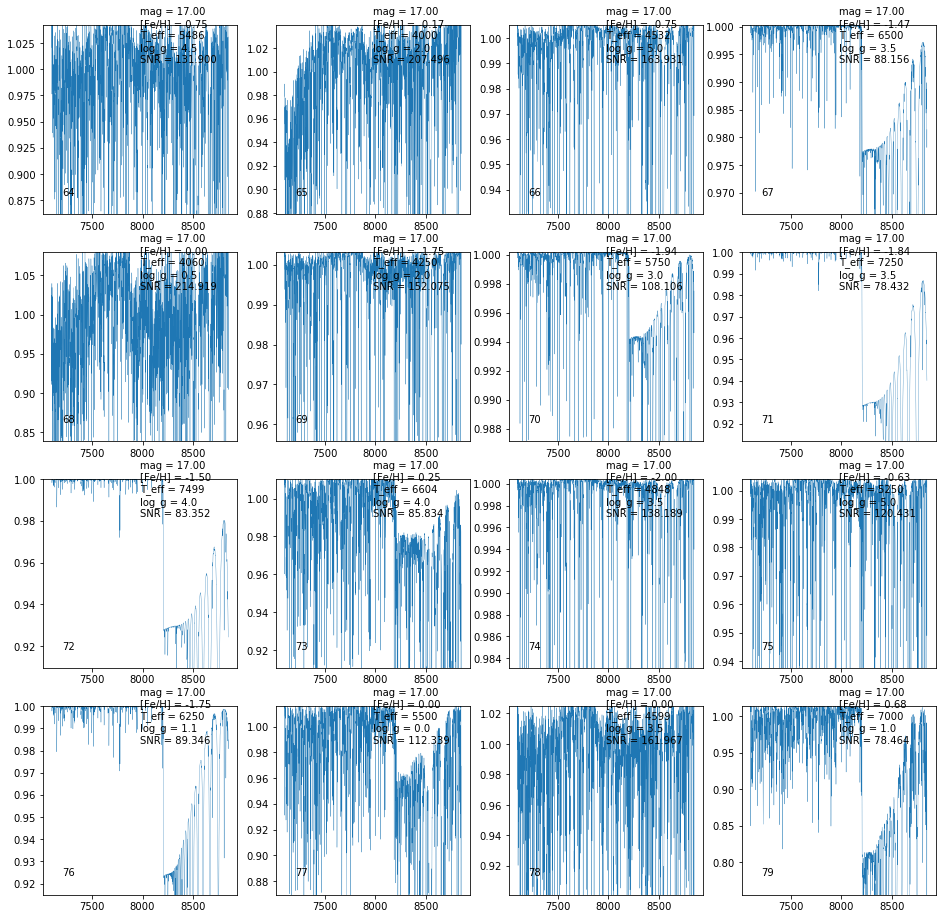

In [11]:
f, axs = plt.subplots(4, 4, figsize=(16, 16))

i = 0
#id = np.random.randint(ds.flux.shape[0] - 16)
id = 64
for ax in axs.flatten():
    idx = np.digitize([4000, 8000], ds.wave)
    wave = ds.wave
    flux = ds.get_flux(np.s_[id + i, :])
    
    mm = np.median(flux[idx[0]:idx[1]])
    
    ax.plot(wave, flux / mm, lw=0.3)
    mm = np.quantile(flux / mm, [0.05, 0.95])
    ax.set_ylim(mm[0], mm[1])

    ax.text(0.1, 0.1, str(id + i), transform=ax.transAxes)
    ax.text(0.5, 0.8, 'mag = %.2f \n[Fe/H] = %.2f \nT_eff = %.0f \nlog_g = %.1f \nSNR = %.3f' 
            % (ds.params['mag'][id + i], ds.params['Fe_H'][id + i], ds.params['T_eff'][id + i], ds.params['log_g'][id + i], ds.params['snr'][id + i]), transform=ax.transAxes)
    i += 1
    
plt.savefig(os.path.join(DATASET_PATH, 'examples.png'))

# Run PCA over flux data

In [12]:
ds.shape

(10000, 4096)

In [13]:
flux = ds.get_flux(np.s_[:, :])
flux.shape

(10000, 4096)

In [14]:
X = np.log(flux)

In [15]:
SVD_PATH = '/scratch/ceph/swei20/data/pfsspec/train/ae/dataset/bosz/nowave/norm_mr_10k'

In [16]:
C = np.dot(X.transpose(), X)
C.shape

(4096, 4096)

In [17]:
U, S, V = np.linalg.svd(C)
U.shape, S.shape, V.shape

((4096, 4096), (4096,), (4096, 4096))

In [18]:
with h5py.File(SVD_PATH, 'w') as f:
    f.create_dataset('flux', data=flux)
    f.create_dataset('X', data=X)
    f.create_dataset('U', data=U)
    f.create_dataset('S', data=S)
    f.create_dataset('V', data=V)

## Decline of eigenvalues

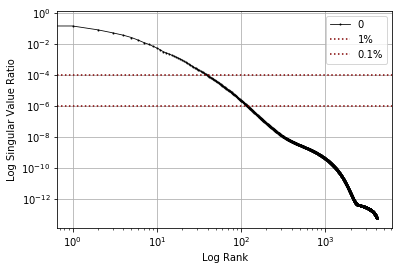

In [19]:
plot_svd_s([S])

## Eigenvectors

Eigenvalues drop to unity by $i = 30$, yet high order eigenspectra still seem to contain information relevan to line strengths.

In [20]:
ds.wave

array([7100.21362305, 7100.64086914, 7101.06811523, ..., 8848.93188477,
       8849.35913086, 8849.78637695])

NameError: name 'avg' is not defined

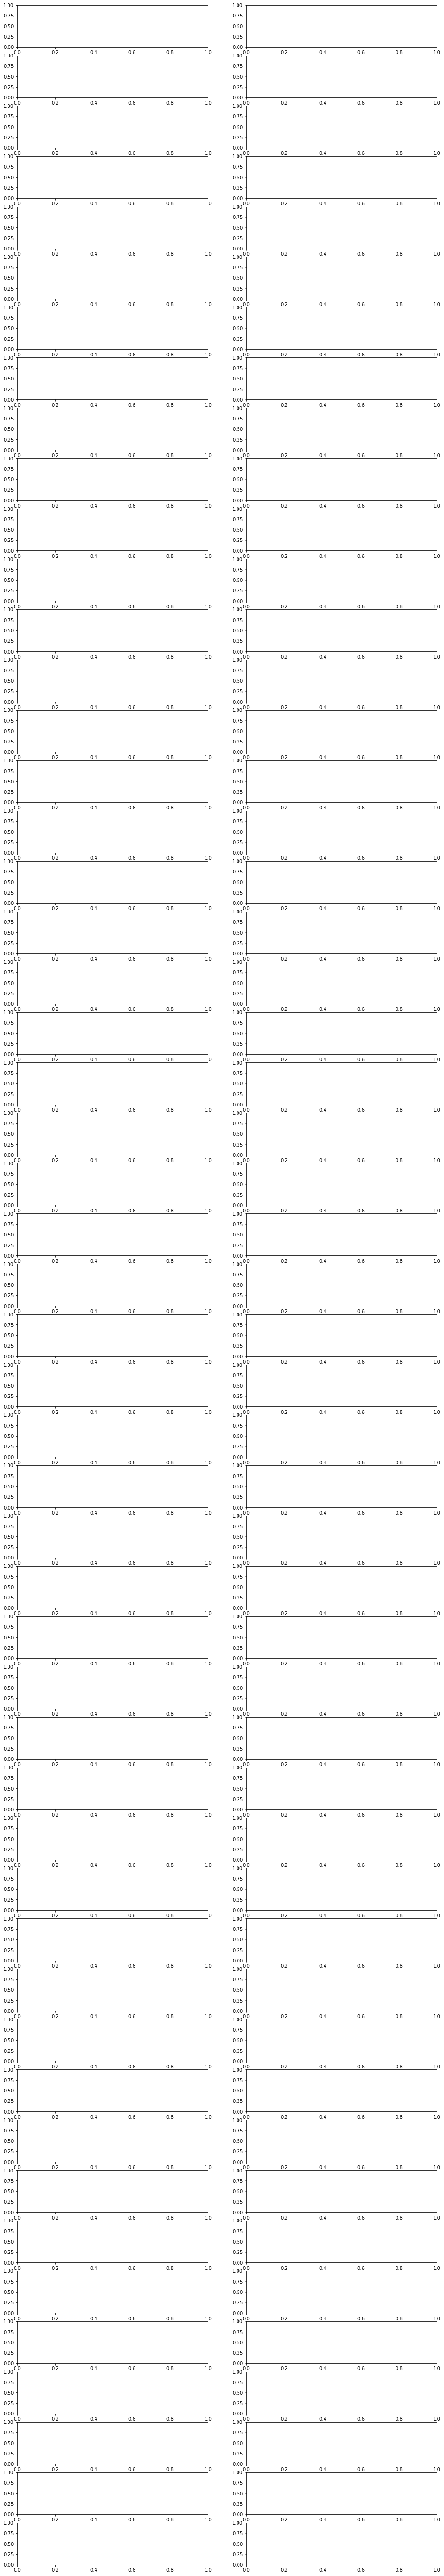

In [21]:
N = 50

f, axs = plt.subplots(N + 1, 2, figsize=(16, 2 * N), squeeze=False)

axs[0, 0].plot(ds.wave, avg, lw=0.3, c='r')
axs[0, 1].plot(ds.wave, avg, lw=0.3, c='r')
# axs[0, 1].set_xlim(8000, 9000)

for i in range(N):
    axs[i + 1, 0].plot(ds.wave, U[:, i], lw=0.3)
    axs[i + 1, 1].plot(ds.wave, U[:, i], lw=0.6)
    
#     axs[i + 1, 1].set_xlim(8000, 9000)

# Calculate principal components and expand on truncated basis

In [ ]:
M = 50

PC = np.dot(X, U[:, 0:M])
PC.shape

In [ ]:
plt.plot()

In [ ]:
f, axs = plt.subplots(int(np.ceil(M / 4)), 4, figsize=(12, 3 * np.ceil(M / 4)))
axs = axs.flatten()

for i in range(M - 1):
    axs[i].plot(PC[:, i], PC[:, i + 1], '.', ms=1)

# Reconstruct from truncated basis

In [ ]:
rflux = np.exp(np.dot(PC, U[:, 0:M].transpose()))
rflux.shape

In [ ]:
N = 20
f, axs = plt.subplots(2 * N, 2, figsize=(16, 4 * N), squeeze=False)

for i in range(N):
    axs[2 * i, 0].plot(wave, flux[i, :], lw=0.3)
    axs[2 * i, 0].plot(wave, rflux[i, :], lw=0.6)
    
    axs[2 * i, 1].plot(wave, flux[i, :], lw=0.3)
    axs[2 * i, 1].plot(wave, rflux[i, :], lw=0.6)
#     axs[2 * i, 1].set_xlim(8000, 9000)
    
    axs[2 * i + 1, 0].plot(wave, (flux[i, :] - rflux[i, :]) / flux[i, :], lw=0.5)
    
    axs[2 * i + 1, 1].plot(wave, (flux[i, :] - rflux[i, :]) / flux[i, :], lw=0.5)
#     axs[2 * i + 1, 1].set_xlim(8000, 9000)

In [ ]:
PC